# Modeling multi-photon quantum walk in QuTiP

Importing required libraries:

In [1]:
from qutip import *
import matplotlib.pyplot as plt
import numpy as np

import time
#import psutil


ModuleNotFoundError: No module named 'qutip'

ModuleNotFoundError: No module named 'qutip'

Creating class "system" which will create set of operators and Hamiltonian respective to given parameters:

In [2]:
class system:
    def __init__(self, ham_matrix, psi_init, fock_dim):
        self.a = []
        for i in range(0,len(ham_matrix)):
            op_list = []
            for j in range(0,len(ham_matrix)):
                if j == i:
                    op_list.append(destroy(fock_dim))
                else:
                    op_list.append(qeye(fock_dim))
            self.a.append(tensor(op_list))
        
        for i in range(0,len(ham_matrix)):
            for j in range(0,len(ham_matrix)):
                if i == 0 and j == 0:
                    self.H = ham_matrix[0][0]*self.a[0].dag()*self.a[0]
                else:
                    self.H = self.H + ham_matrix[i][j]*self.a[i].dag()*self.a[j]
                    
    def gen_c_ops(self, gamma):
        c_ops_list = []
        for i in range(0,len(self.a)):
            c_ops_list.append(gamma*self.a[i])
        return c_ops_list       

    def gen_cormatrix_2(self, psi):
        cormatrix = np.zeros((len(self.a),len(self.a)), dtype = complex)
        for i in range(0,len(self.a)):
            for j in range(0,len(self.a)):
                temp_op = self.a[i].dag()*self.a[j].dag()*self.a[i]*self.a[j]
                cormatrix[i][j] = temp_op.matrix_element(psi.dag(),psi)
        return cormatrix
    
    def gen_cormatrix_2_loss(self, psi):
        cormatrix = np.zeros((len(self.a),len(self.a)), dtype = complex)
        for i in range(0,len(self.a)):
            for j in range(0,len(self.a)):
                temp_op = self.a[i].dag()*self.a[j].dag()*self.a[i]*self.a[j]
                temp_op_j = psi*temp_op
                cormatrix[i][j] = temp_op_j.tr()
        return cormatrix

Creating function "psi_init" which will create initial state out of given vector:

In [3]:
def psi_init(psi_vector, fock_dim):
    psi_list = []
    for i in range(0,len(psi_vector)):
        psi_list.append(fock(fock_dim,psi_vector[i])) 
    return tensor(psi_list)

To perform simulation we need to define matrix of Hamiltonian coefficients, it can be done manually by creating array. In our case we will be creating matrix for a unifrom waveguide array with equal coupling coefficients and propagation constants. It will be done in form of a function which takes number of waveguides, propagation constant and coupling coefficient as an input and returns num_wg x num_wg matrix for our Hamiltonian.

In [4]:
def uniform_array(num_wg, b, k):
    ham_matrix = np.zeros((num_wg,num_wg))
    for i in range(0,num_wg):
        for j in range(0,num_wg):
            if i == j:
                ham_matrix[i][j] = b
            elif i == j+1 or j == i+1:
                ham_matrix[i][j] = k
    return ham_matrix 

We will simulate uniform array of 10 waveguides. First we need to create initial state which represents two photons being incident into waveguides number 4 and 5. We will create respective vector and then use our "psi_init" function to transform it to a quantum object so that QuTiP functions could use it as an inpit. 

In [21]:
n = 6
psi_vector = np.zeros(n)
psi_vector = psi_vector.astype(int)
psi_vector[2] = 1
psi_vector[3] = 1
psi0 = psi_init(psi_vector, 3)

Now we will initialize out system using our "system" class. It will create all required operators and Hamiltonian so we could feed it forward to the solver.

In [22]:
hm = uniform_array(n, 1, 1)
qws = system(hm, psi0, 3)
times = np.linspace(0,5,100)

Now we will use QuTiP function "sesolve" to calculate dynamic unitary evolution of state "psi0" in a system of 10 waveguides.

In [23]:
start = time.time()
result_un = sesolve(qws.H, psi0, times, [])
end = time.time()
print(end - start)

#result_loss = mesolve(qws.H, psi0, times, qws.gen_c_ops(0.25), [])

0.11129140853881836


Finally, we will visuallize our results by plotting evolution of given expectation value over time.

In [70]:
n = list(range(2,11))
calc_time = []
mem_use = []
mem_bg = 0
process = psutil.Process(os.getpid())
for i in range(0,len(n)):
    psi_vector = np.zeros(n[i])
    psi_vector = psi_vector.astype(int)
    psi_vector[int(round(n[i]/2))] = 1
    psi_vector[int(round(n[i]/2-1))] = 1
    psi0 = psi_init(psi_vector, 3)
    hm = uniform_array(n[i], 1, 1)
    qws = system(hm, psi0, 3)
    times = np.linspace(0,5,100)
    start = time.time()
    result_un = sesolve(qws.H, psi0, times, [])
    end = time.time()
    calc_time.append(end - start)
    mem_use.append(process.memory_info().rss/1024/1024)
    print(process.memory_info().rss/1024/1024)
    print(end - start)

111.3203125
0.05113506317138672
111.34765625
0.04963254928588867
111.37890625
0.05163860321044922
111.546875
0.06018233299255371
112.42578125
0.1143186092376709
114.78125
0.25615429878234863
119.81640625
0.7988345623016357
124.91015625
1.6383731365203857
154.578125
6.876298666000366


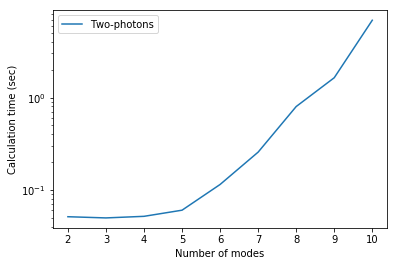

In [71]:
plt.semilogy(n, calc_time, label = 'Two-photons')
plt.legend()
plt.ylabel('Calculation time (sec)')
plt.xlabel('Number of modes')
plt.show()

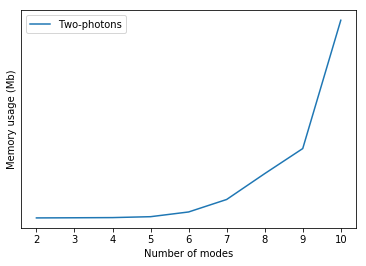

In [72]:
plt.semilogy(n, mem_use, label = 'Two-photons')
plt.legend()
plt.ylabel('Memory usage (Mb)')
plt.xlabel('Number of modes')
plt.show()

In [60]:
print(mem_use)

[6426.25]


7847.6328125


In [61]:
print(process.memory_info().rss)

NameError: name 'process' is not defined

In [64]:
import os


117.38671875
